<a href="https://colab.research.google.com/github/mohammed21kamal/AI-Faction-Expressions/blob/main/Copy_of_PredictedRating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from IPython.display import Image
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [4]:
df = pd.read_csv("ratings_small.csv")


In [5]:
df = df.sample(10000)

In [6]:
df

,userId,movieId,rating,timestamp
70939,496,356,5.0,834060194
73391,511,282,4.0,829352433
20587,138,106100,3.0,1440380757
99722,666,539,1.0,838921120
67168,471,3702,4.5,1239657373
...,...,...,...,...
60531,439,3515,2.0,1041115586
6179,33,231,3.0,1032769595
64103,461,101,3.5,1090908846
4387,23,3088,2.5,1148671916


In [7]:
class MovieDataset(Dataset):
    def __init__(self, userId, movieId, rating):
        self.userId = userId
        self.movieId = movieId
        self.rating = rating

    def __len__(self):
        return len(self.userId)

    def __getitem__(self, item):
        userId = self.userId[item]
        movieId = self.movieId[item]
        rating = self.rating[item]
        return torch.tensor(userId), torch.tensor(movieId), torch.tensor(rating)

In [8]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)
#   Split Data Into Train And Validation Data :
train_set, test_set = train_test_split(df, test_size = 0.1)

In [9]:
#   Create Torch Datasets :
train_dataset = MovieDataset(train_set.userId.values, train_set.movieId.values, train_set.rating.values)
test_dataset = MovieDataset(test_set.userId.values, test_set.movieId.values, test_set.rating.values)
train_loader = DataLoader(train_dataset, batch_size = 8)
test_loader = DataLoader(test_dataset, batch_size = 8)

In [10]:
n_factors = 20
n_users = len(df.userId.unique())
n_items = len(df.movieId.unique())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        #   Create Vector Embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_items, n_factors)
        self.mlp = nn.Sequential(
            nn.Linear(n_factors*2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
)

    def forward(self, user, movie):
        #   Matrix Multiplication
        user_embedding = self.user_factors(user)
        movie_embedding = self.movie_factors(movie)
        x = torch.cat((user_embedding, movie_embedding), dim=1)
        return self.mlp(x).view(-1)

In [107]:
#   Training Function
accuracies = []  # قائمة لتخزين قيم الدقة
losses = []
def train(num_epochs):
    best_accuracy = 0.0

    print("Begin Training...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        #   Training Loop
        for user, movie, rating in tqdm(train_loader, desc="Processing"):
            #   Make Prediction For This Batch
            user, movie, rating = user.cuda(), movie.cuda(), rating.cuda()
            optimizer.zero_grad()
            outputs = model(user, movie).view(-1)

            #   Calculate accuracy
            predicted_labels = torch.round(outputs)  # لتقريب القيم إلى 0 أو 1
            correct_predictions += torch.sum(torch.eq(predicted_labels, rating)).item()
            total_samples += len(rating)

            #   Calculate Loss
            loss = loss_fn(outputs, rating.float())
            loss.backward()     #   Backpropagate The Loss
            optimizer.step()    #   Adjust Parameters Based On The Calcuated Gradients
            running_train_loss += loss.item()   #   Track The Loss Value

        #   Calculate Training Of The Epoch
        train_loss_value = running_train_loss / len(train_loader)
        accuracy_value = correct_predictions / total_samples

        losses.append(train_loss_value)
        accuracies.append(accuracy_value)

        if epoch % 10 == 0:
            print('Batch', epoch, "Training Loss Is: %.4f, Accuracy Is: %.4f" % (train_loss_value, accuracy_value))


In [127]:
num_epochs = 10
model = MatrixFactorization(n_users, n_items, n_factors)
model = model.to(device)
#   MSE Loss
loss_fn = torch.nn.MSELoss()
#   ADAM Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [128]:
model.train()

MatrixFactorization(
  (user_factors): Embedding(661, 20)
  (movie_factors): Embedding(3468, 20)
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [129]:
train(num_epochs)

Begin Training...


Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing:   0%|          | 0/1125 [00:00<?, ?it/s]

Batch 10 Training Loss Is: 0.4799, Accuracy Is: 0.4439


In [130]:
print(losses)

[1.9872704032593302, 1.0237171487344636, 0.917170490367545, 0.8333496312830183, 0.7588900619745255, 0.6909799535572528, 0.6266133779353565, 0.5672055212871896, 0.5097481110220154, 0.45711672171619205, 2.215166169868575, 1.0380933838950264, 0.9322628717952305, 0.8531656647192107, 0.7836393162707488, 0.7200911990139219, 0.658720764324069, 0.6012313794096311, 0.546366290350755, 0.4939878044525782, 0.4456578891111745, 0.40056626409954493, 0.35882402471659913, 0.31958307743155295, 0.28376189067421687, 0.25098439229072794, 0.22190100947105224, 0.1966243805380331, 0.1739522642079327, 0.15534925236552954, 0.13861529427042438, 0.12338174841470188, 0.11173145913394789, 0.10075611477303836, 0.09178825260822972, 0.08342616922408343, 0.07766512303447558, 0.07485524860065844, 0.07130373603478074, 0.06803615951248342, 0.06655983258701033, 0.07156418210247324, 0.07394284664177232, 0.07116268533178502, 0.06255459121573302, 0.054509794063452216, 0.054071585239635574, 0.06135260614049103, 0.0721434933866

ValueError: x and y must have same first dimension, but have shapes (10,) and (220,)

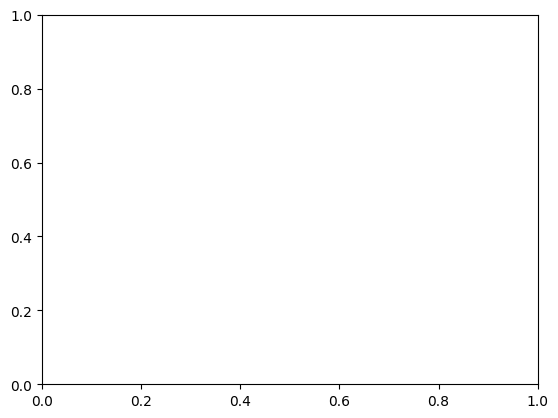

In [131]:
plt.plot(range(1, num_epochs+1), losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')

ValueError: x and y must have same first dimension, but have shapes (10,) and (220,)

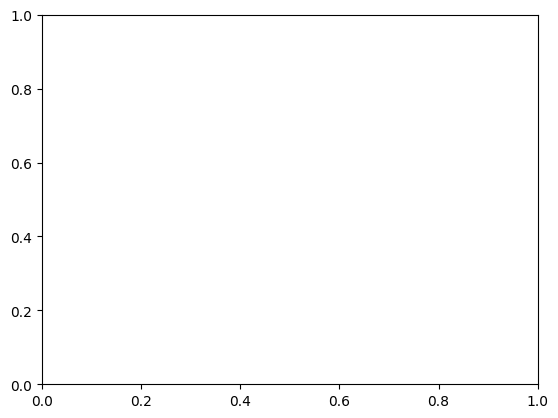

In [132]:
plt.plot(range(1, num_epochs+1), accuracies)
plt.ylabel('accuracy')
plt.xlabel('Epochs')

In [133]:
#   Set The Model To Evaluation Model
model.eval()

#   Initiate Values
total_loss = 0.0
num_samples = len(test_loader)

with torch.no_grad():
    for(user, movie, rating) in test_loader:
        user, movie, rating = user.cuda(), movie.cuda(), rating.cuda()
        outputs = model(user, movie).view(-1)
        mae = nn.L1Loss()
        loss = mae(outputs, rating)
        total_loss += loss.item()

print(f"MAE= {total_loss/num_samples}")

MAE= 0.8291880950927735


In [134]:
#   Choosing A Random Sample
example_set = test_set.sample(10)

In [135]:
#   Create A PrettyTable Torch Datasets
example_dataset = MovieDataset(example_set.userId.values, example_set.movieId.values, example_set.rating.values)
example_loader = DataLoader(example_dataset, batch_size = 8)

In [136]:
#   Create A PrettyTable To Store Values
table = PrettyTable()
table.field_names = ["User ID", "Actual Rating", "Predicted Rating"]

#   Set The Model To Evaluation Mode
model.eval()

#   Make Predicted
for(user, movie, rating) in example_loader:
    with torch.no_grad():
        user, movie, rating = user.cuda(), movie.cuda(), rating.cuda()
        outputs = model(user, movie).view(-1)

    #   Print Input, Target, And Predicted Values
    for i in range(len(rating)):
        userId = user[i].item()
        rating_value = rating[i].item()
        predicted_value = outputs[i].item()

        table.add_row([userId, rating_value, round(predicted_value*2, 0) / 2])

In [137]:
#   Print The Results
print(table)

+---------+---------------+------------------+
| User ID | Actual Rating | Predicted Rating |
+---------+---------------+------------------+
|   429   |      4.0      |       3.5        |
|   364   |      5.0      |       4.0        |
|   475   |      4.0      |       4.5        |
|   576   |      2.5      |       3.0        |
|   374   |      3.0      |       4.0        |
|   284   |      4.5      |       5.5        |
|   270   |      4.0      |       4.5        |
|   537   |      4.0      |       5.0        |
|   318   |      3.0      |       5.0        |
|   481   |      3.0      |       4.0        |
+---------+---------------+------------------+
